SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. 
It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and 
their related extensions (see papers for details and citations).

Helpful links for more information:

* [Lundberg et al. original paper](https://arxiv.org/pdf/1705.07874.pdf) 
* [Lundberg @H20World: Explainable Machine Learning with Shapley Values](https://www.youtube.com/watch?v=ngOBhhINWb8) 
* [Lundberg @Microsoft Research: Explainable AI for Science and Medicine](https://www.youtube.com/watch?v=B-c8tIgchu0&feature=emb_rel_end)  
* [Watzman @PayPal: SHAP Values for ML Explainability](https://www.youtube.com/watch?v=0yXtdkIL3Xk)  
* Titanic data: https://www.kaggle.com/c/titanic/data  

In [1]:
import xgboost
import sklearn
import shap
import seaborn as sns
import pandas as pd
import string
import numpy as np
import os
import pickle
import re
import time
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML
from matplotlib import pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# analysis

In [2]:
# load data
test_df = pd.read_csv("titanic_test.csv")
train_df = pd.read_csv("titanic_train.csv")

# tally missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['#missing', '%'])
display(missing_data.head(5))

,#missing,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


### feature generation

In [3]:
# form number of family members on board with each passenger
data = [train_df, test_df]
for dataset in data:
    dataset['num_family'] = dataset['SibSp'] + dataset['Parch']
    
train_df.drop(columns=['SibSp','Parch'],inplace=True)
test_df.drop(columns=['SibSp','Parch'],inplace=True)

# rename some columns
train_df.rename(columns=dict(Pclass='ticket_class', PassengerId='passenger_id'),inplace=True)
test_df.rename(columns=dict(Pclass='ticket_class', PassengerId='passenger_id'),inplace=True)

In [4]:
# from the Cabin number we can parse the deck level
# level 8 represents a deck level that we could not infer from the Cabin number
# or where the Cabin number was missing
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['deck'] = dataset['deck'].map(deck)
    dataset['deck'] = dataset['deck'].fillna(0)
    dataset['deck'] = dataset['deck'].astype(int)
    dataset['deck'] = dataset['deck'].fillna('NA')

# we can now drop the cabin feature
train_df.drop(columns=['Cabin'], inplace=True)
test_df.drop(columns=['Cabin'], inplace=True)

In [5]:
# age imputation
# https://www.mikulskibartosz.name/fill-missing-values-using-random-forest/

def impute_age(titanic):

    titanic[titanic==np.inf]=np.nan
    got_age = pd.isnull(titanic['Age']) == False

    titanicWithAge = titanic[got_age]
    titanicWithoutAge = titanic[~got_age]
    variables = ['ticket_class', 'num_family', 'Fare', 'Age','passenger_id']
    one_hot_encoded_embarked = pd.get_dummies(titanicWithAge['Embarked'], prefix='emb')
    one_hot_encoded_sex = pd.get_dummies(titanicWithAge['Sex'])
    titanicWithAge = titanicWithAge[variables]
    titanicWithAge = pd.concat([titanicWithAge, one_hot_encoded_sex, one_hot_encoded_embarked], axis = 1)

    one_hot_encoded_embarked = pd.get_dummies(titanicWithoutAge['Embarked'], prefix='emb')
    one_hot_encoded_sex = pd.get_dummies(titanicWithoutAge['Sex'])
    titanicWithoutAge = titanicWithoutAge[variables]
    titanicWithoutAge = pd.concat([titanicWithoutAge, one_hot_encoded_sex, one_hot_encoded_embarked], axis = 1)

    independentVariables = ['ticket_class', 'female', 'male', 'num_family', 'Fare', 
                            'emb_C', 'emb_Q', 'emb_S']

    rfModel_age = RandomForestRegressor(random_state=100)
    rfModel_age.fit(titanicWithAge[independentVariables], titanicWithAge['Age'])

    generatedAgeValues = rfModel_age.predict(X = titanicWithoutAge[independentVariables])

    titanicWithoutAge['Age'] = generatedAgeValues.astype(int)
    data = titanicWithAge.append(titanicWithoutAge)
    data = data[['Age','passenger_id','emb_C', 'emb_Q', 'emb_S']]
    data.rename(columns=dict(Age='age'), inplace=True)
    return data

train_imputed_df = train_df.drop(columns='Age').merge(impute_age(train_df), on='passenger_id')
train_imputed_df['age'] = train_imputed_df['age'].astype(int)

test_df.dropna(subset=['Fare'], inplace=True) # a few missing values here...just nix
test_imputed_df = test_df.drop(columns='Age').merge(impute_age(test_df), on='passenger_id')
test_imputed_df['age'] = test_imputed_df['age'].astype(int)

In [6]:
# Fare is the price for multiple people in the party.
# Correct by calculating ticket_price per individual.

def price_per_passenger(x):
    return round(x.mean() / len(x), 2)

price_per_passenger_df = train_imputed_df.groupby('Ticket').Fare.agg(price_per_passenger).to_frame().reset_index()
price_per_passenger_df.rename(columns=dict(Fare='ticket_price'), inplace=True)
train_imputed_df = train_imputed_df.merge(price_per_passenger_df, on='Ticket', how='left')
train_imputed_df.drop(columns=['Fare','Ticket'], inplace=True)

In [7]:
# here we add various features:
# - parse name and convert titles to codes
# - create one hot encoding for gender
# - add silly features that should not matter in feature importance to test feature importance algorithms
genders = {"male": 0, "female": 1}

titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']

cols_to_drop = ['Name', 'Embarked','Sex']

data = [train_imputed_df, test_imputed_df]

np.random.seed(1)

for dataset in data:
    
    # set gender logical
    dataset['is_female'] = dataset['Sex'].map(genders)
    
    # extract titles
    dataset['title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['title'] = dataset['title'].replace(rare_titles, 'Rare')
    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')
    
    # convert titles into numbers
    dataset['title'] = dataset['title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['title'] = dataset['title'].fillna(0)

    # add silly feature to test feature importance
    dataset['surname_length'] = [len(s[0]) for s in dataset.Name.str.split(',')]
    dataset['random'] = np.random.randint(1,100, len(dataset))
    
    # drop columns
    dataset.drop(columns=cols_to_drop, inplace=True)


X_train_df = train_imputed_df.drop(columns=['Survived'])
X_train_df.set_index('passenger_id', inplace=True)
y_train = train_imputed_df['Survived'].values

In [8]:
# display data set with survived feature tacked on
# just for display purposes and interacting with the data
X_train_with_survival_df = X_train_df.copy()
X_train_with_survival_df['survived'] = y_train
display(X_train_with_survival_df)

,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title,surname_length,random,survived
passenger_id,,,,,,,,,,,,,
1,3,1,8,22,0,0,1,7.25,0,1,6,38,0
2,1,1,3,38,1,0,0,71.28,1,3,7,13,1
3,3,0,8,26,0,0,1,7.92,1,2,9,73,1
4,1,1,3,35,0,0,1,26.55,1,3,8,10,1
5,3,0,8,35,0,0,1,8.05,0,1,5,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,0,8,27,0,0,1,13.00,0,5,8,97,0
888,1,0,2,19,0,0,1,30.00,1,2,6,37,1
889,3,3,8,20,0,0,1,11.72,1,2,8,99,0


In [9]:
# train a model
model = xgboost.train({"learning_rate": 0.01, "seed":100}, 
                      xgboost.DMatrix(X_train_df, label=y_train, enable_categorical=True), 
                      100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_df)

shap_values_df = pd.DataFrame(shap_values)
shap_values_df['passenger_id'] = X_train_df.index.values
shap_values_df.set_index('passenger_id', inplace=True)

# row_sample = np.random.randint(0, len(X_train_df), 3)
pid_sample = [446, #166, # young and survived
             80, # model not confident they will survive, 
             615, #high title
             ]

# display title code for reference since it appears in
# the force plots
display(HTML('<h3 style="color:cornflowerblue">TITLE CODES</h3>'))
display(pd.DataFrame(titles, index=[0]).style.hide_index())

display(HTML('<h3 style="color:cornflowerblue">SAMPLE SHAP EXPLANATIONS</h3>'))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
for pid in pid_sample:
    passenger = X_train_df.loc[[pid]]
    passenger_shap_values = shap_values_df.loc[pid].values
    display(passenger.reset_index().style.hide_index().set_precision(2))#.set_table_styles(styles))
    display(shap.force_plot(explainer.expected_value, passenger_shap_values, passenger))


Mr,Miss,Mrs,Master,Rare
1,2,3,4,5


passenger_id,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title,surname_length,random
446,1,2,1,4,0,0,1,81.86,0,4,5,50


passenger_id,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title,surname_length,random
80,3,0,8,30,0,0,1,6.24,1,2,7,39


passenger_id,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title,surname_length,random
615,3,0,8,35,0,0,1,8.05,0,1,11,77


In [10]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_df)

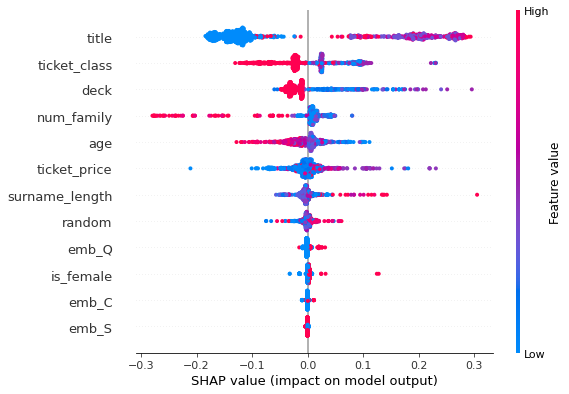

In [11]:
shap.summary_plot(shap_values, X_train_df)

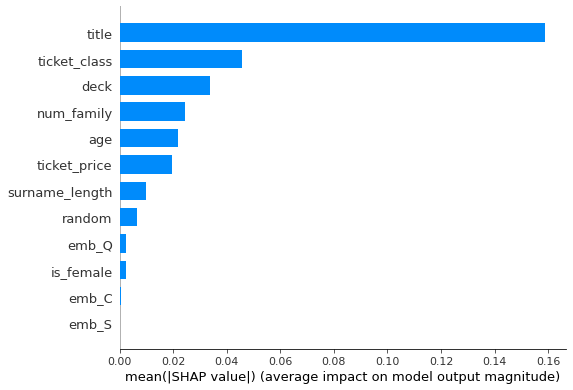

In [12]:
shap.summary_plot(shap_values, X_train_df, plot_type="bar")

# assessing test split

In [13]:
def get_top_shap_features(shap_values, features, positive_class_index=1, classifier=None):
    if isinstance(shap_values, list):
        shap_values = shap_values[positive_class_index]
    vals = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame(list(zip(features, vals)), 
                                      columns=['feature','mean_abs_shap_value'])
    feature_importance.sort_values(by=['mean_abs_shap_value'], ascending=False, inplace=True)
    if classifier is not None:
        feature_importance['classifier'] = classifier
    df = feature_importance.reset_index(drop=True)
    df['rank'] = [*range(1,len(df)+1)]
    return df

def acc(f, X_test, Y_test):
    try:
        y_pred = f(X_test)
    except:
        y_pred = [round(value) for value in f(xgboost.DMatrix(X_test, label=Y_test))]

    return np.round((100*np.sum(y_pred == Y_test)/len(Y_test)), 2)

def print_accuracy(f, X_test, Y_test):
    print("Accuracy = {0}%".format(acc(f, X_test, Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def test_model(X_train, Y_train, X_test, Y_test, model_type = 'xgboost', seed = 100):
    
    if model_type == 'knn':
        
        model = sklearn.neighbors.KNeighborsClassifier()

    elif model_type == 'svm':
        
        model = sklearn.svm.SVC(kernel='rbf', probability=True, random_state=seed)
        
    elif model_type == 'lr':
        
        model = sklearn.linear_model.LogisticRegression(max_iter=1000, random_state=seed)
        
    elif model_type == 'dt':
        
        model = sklearn.tree.DecisionTreeClassifier(min_samples_split=2, random_state=seed)

    elif model_type == 'rf':
        
        model = sklearn.ensemble.RandomForestClassifier(n_estimators=100, 
                                         max_depth=None, 
                                         min_samples_split=2, 
                                         random_state=seed)
        
    elif model_type =='mlp':
        
        from sklearn.neural_network import MLPClassifier
        from sklearn.preprocessing import StandardScaler
        
        model = MLPClassifier(solver='adam', 
                             alpha=0.0001, 
                             hidden_layer_sizes=(5, 2),
                             max_iter=1000,
                             random_state=seed)
        
        
        # fit scaler only to the training data
        scaler = StandardScaler()
        scaler.fit(X_train)


        # normalize both training and test data
        columns = X_train.columns
        X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)
        
    elif model_type == 'xgb':
        
        model = xgboost.train({"learning_rate": 0.01, "seed": seed}, 
                              xgboost.DMatrix(X_train, label=Y_train), 
                              num_boost_round=100)

    # get model name
    model_name = model.__class__.__name__    
    print(f'{model_name}', flush=True)
    
    # fit the model
    if model_type != 'xgb':
        model.fit(X_train, Y_train)
    
    # test model accuracy
    accuracy = acc(model.predict, X_test, Y_test)
    
    # explain the model
    if model_type == 'xgb':
        explainer = shap.TreeExplainer(model, X_train)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, X_train)
    
    # calculate SHAP values
    shap_values = explainer.shap_values(X_test)
    
    # get top features in model via SHAP values
    shap_summary_df = get_top_shap_features(shap_values, X_test.columns, classifier=model_name)
    shap_summary_df['accuracy'] = f'{accuracy}%'
    
    # return the result
    return dict(model=model, shap_values=shap_values, explainer=explainer, shap_summary=shap_summary_df)

def print_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(df)

In [14]:
# create train/test data
seed = 100
test_size=0.2 # partition data into train/test based on an 80/20 split, respectively
n_sample=None # set this to a positive integer to train on an n_sample number of observations

if n_sample is not None:
    X_train,X_test,Y_train,Y_test = train_test_split(X_train_df.head(n_sample), y_train[0:n_sample], 
    test_size=test_size, random_state=seed)
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_train_df, y_train, test_size=test_size, random_state=0)

In [15]:
# NOTE: THIS SECTION WILL TAKE SOME TIME, TYPICALLY AROUND 30-60 MINUTES
# settting overwrite=False will store the models on disk in a pickle file
# and load that file (quickly) when the cell is subsequently run

model_file = "titanic_models.pkl"
overwrite = False

got_data = os.path.exists(model_file)

if got_data and not overwrite:
    print(f'loading {model_file}')
    inference = pickle.load(open(model_file, "rb"))
else:

    inference = dict()
    models = ['lr','dt','rf','mlp','xgb']

    for m in models:

        inference[m] = test_model(X_train, Y_train, X_test, Y_test, model_type=m, seed=seed)

    pickle.dump(inference, open(model_file , "wb"))


loading titanic_models.pkl


In [16]:
# print top features for each classifier
df = pd.concat([inference[k]['shap_summary'] for k in inference.keys()])
df.sort_values(['accuracy','rank'], inplace=True )
df['classifier'] = df['classifier'].str.replace('Booster','XGBoostClassifier')

top=5
by=['classifier','accuracy', 'rank']
top_df = df.groupby(['classifier']).head(top).round(3)
all_df = df.round(3)

display(top_df.set_index(by))

feature  mean_abs_shap_value
classifier             accuracy rank                                   
DecisionTreeClassifier 72.07%   1            title                0.231
                                2     ticket_class                0.095
                                3     ticket_price                0.090
                                4              age                0.084
                                5           random                0.050
LogisticRegression     79.33%   1        is_female                0.170
                                2     ticket_class                0.124
                                3            title                0.098
                                4              age                0.068
                                5       num_family                0.053
MLPClassifier          80.45%   1        is_female                0.157
                                2            title                0.093
                                3     ticket_class                0.067
                                4            emb_C                0.057
                                5       num_family                0.057
XGBoostClassifier      83.24%   1            title                0.146
                                2     ticket_class                0.062
                                3              age                0.030
                                4     ticket_price                0.028
                                5       num_family                0.021
RandomForestClassifier 83.8%    1            title                0.129
                                2        is_female                0.092
                                3     ticket_class                0.058
                                4             deck                0.042
                                5              age                0.041

In [17]:
# perform a cross comaparison

compare_df = all_df.copy()
weights = compare_df.accuracy.str.replace('%','').astype(float)/100
contrib = all_df.mean_abs_shap_value * weights

compare_df['weights'] = weights
compare_df['weighted_SHAP'] = contrib

cross = compare_df.groupby('feature').weighted_SHAP.sum().sort_values(ascending=False)
cross = cross/cross.max()

cross_df = cross.reset_index()
cross_df.insert(0, 'rank', [*range(1,len(cross_df)+1)])
cross_df.style.hide_index()

rank,feature,weighted_SHAP
1,title,1.000000
2,is_female,0.655008
3,ticket_class,0.584954
4,age,0.391566
5,num_family,0.261559
6,ticket_price,0.243782
7,deck,0.199388
8,surname_length,0.145636
9,emb_C,0.123501
10,random,0.119835


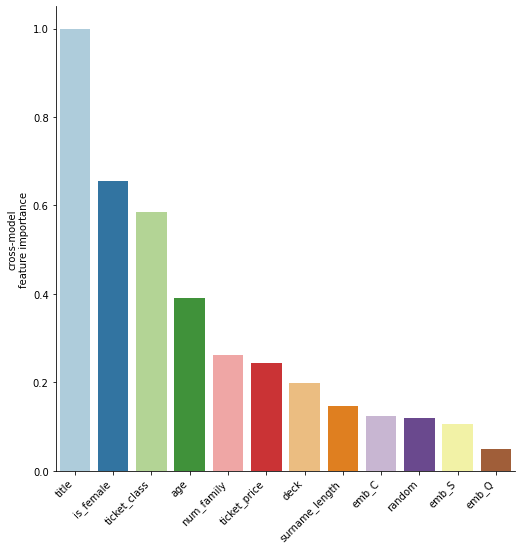

In [18]:
ax = sns.catplot(x='feature', y='weighted_SHAP', data=cross_df, kind='bar', palette='Paired', height=7)
ax.set_xticklabels(rotation=45, horizontalalignment='right')
ax.set_ylabels('cross-model\nfeature importance')
_=ax.set_xlabels('')


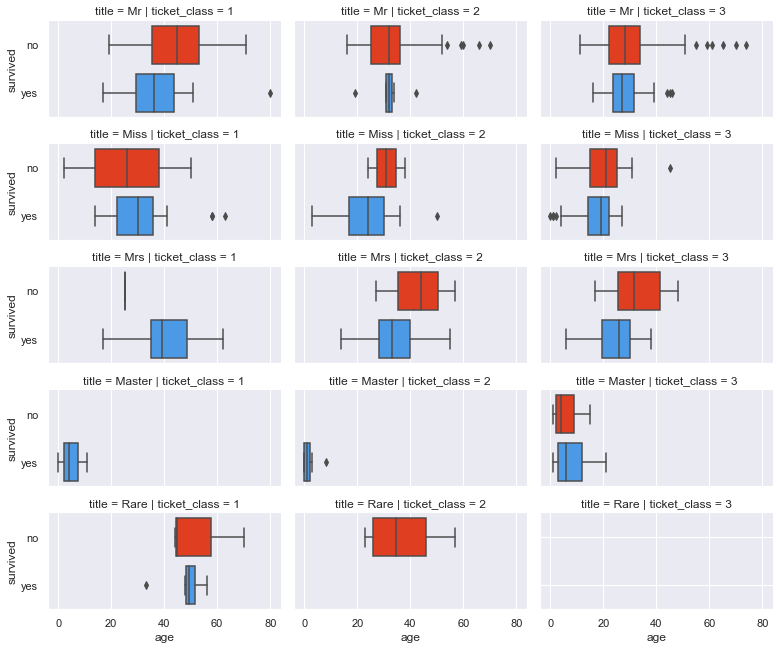

In [22]:
top_features = cross_df.head(4).feature.tolist()

features_to_explore = ['is_female','ticket_class','age','deck','title']

top_df = X_train.copy()[features_to_explore]
top_df['survived'] = ['yes' if s==1 else 'no' for s in Y_train]

title_map = {v: k for k, v in titles.items()}
top_df['title'] = top_df.title.replace(title_map).astype('category')

top_df['sex'] = top_df['is_female'].replace({0 : 'male', 1: 'female'})

deck = {"1:A": 1, "2:B": 2, "3:C": 3, "4:D": 4, "5:E": 5, "6:F": 6, "7:G": 7, "8:U": 8, "NA": 0}
deck_map = {v:k for k, v in deck.items()}

top_df['deck'] = top_df['deck'].astype(int).replace(deck_map).astype('category')
top_df['ticket_class'] = pd.Categorical(top_df['ticket_class'], ordered=True)

sns.set(font_scale=1)
sns.catplot(x="age", y="survived", row="title",
            row_order = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare'],
            col='ticket_class',
            kind="box", 
            orient="h", 
            height=1.8, aspect=2,
            palette=['#ff2800', '#3399ff'],
            data=top_df)
plt.show()

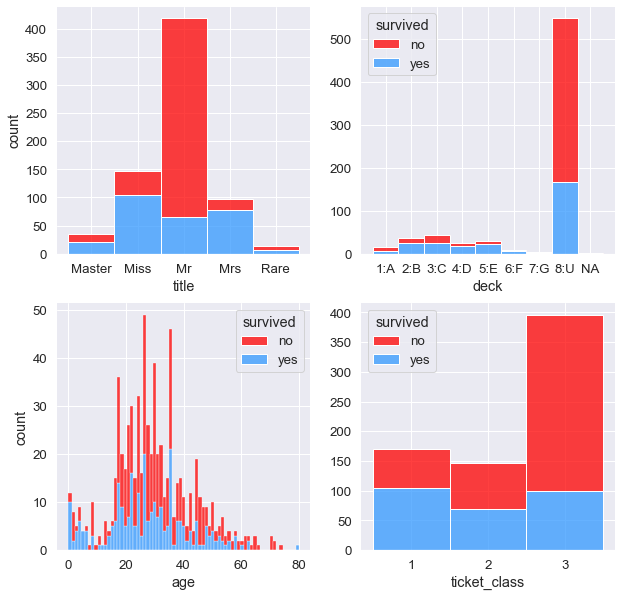

In [23]:
sns.set(font_scale=1.2)
palette=['red', '#3399ff']

fig, axes = plt.subplots(2, 2,  figsize=(10,10))

for i, feature in enumerate(['title','deck','age','ticket_class']):

    ax=axes.flatten()[i]
    _=sns.histplot( 
        top_df,
        x=feature, 
        bins = len(top_df[feature].unique()),
        hue="survived", 
        palette=palette,
        multiple="stack",
        ax=ax
    )

    sns.despine(top = True, left = True)
    if i % 2 == 0:
        ax.set_ylabel('count')
    else:
        ax.set_ylabel('')
        
    ax.grid(b=True, which='minor', color='w', linewidth=0.5)
    if i == 0:
        ax.get_legend().remove()
    
plt.show()